Source: https://www.kaggle.com/masumrumi/a-statistical-analysis-ml-workflow-of-titanic

# Titanic EDA & Machine Learning (replicated from Kaggle)

In [40]:
# Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# ignore all warnings
import warnings
warnings.filterwarnings('ignore')

In [41]:
# Datasets
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

# make columns lowercase
train.columns = train.columns.str.lower()
test.columns = test.columns.str.lower()

## Overview of Datasets

In [42]:
print('The shape of the train dataset is (row, column): ' + str(train.shape) + '\n')
print(train.info())
print()
print('The shape of the test dataset is (row, column): ' + str(test.shape) + '\n')
print(test.info())

The shape of the train dataset is (row, column): (891, 12)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  891 non-null    int64  
 1   survived     891 non-null    int64  
 2   pclass       891 non-null    int64  
 3   name         891 non-null    object 
 4   sex          891 non-null    object 
 5   age          714 non-null    float64
 6   sibsp        891 non-null    int64  
 7   parch        891 non-null    int64  
 8   ticket       891 non-null    object 
 9   fare         891 non-null    float64
 10  cabin        204 non-null    object 
 11  embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None

The shape of the test dataset is (row, column): (418, 11)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column   

We can see that there are missing (NA) values in Age, Cabin, and Embarked columns in both datasets

In [43]:
# finding missing values in dataset
def missing_percentage(df):
    """ This function takes a dataframe as input and returns two columns, total missing values and its percentage"""
    total = df.isnull().sum().sort_values(ascending = False) # total number of NA values
    percent = round(df.isnull().sum().sort_values(ascending = False)/len(df) * 100, 2) # percentage of NA values
    return pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])

missing_percentage(train)

,Total,Percent
cabin,687,77.10
age,177,19.87
embarked,2,0.22
fare,0,0.00
ticket,0,0.00
parch,0,0.00
sibsp,0,0.00
sex,0,0.00
name,0,0.00
pclass,0,0.00


In [44]:
missing_percentage(test)

,Total,Percent
cabin,327,78.23
age,86,20.57
fare,1,0.24
embarked,0,0.00
ticket,0,0.00
parch,0,0.00
sibsp,0,0.00
sex,0,0.00
name,0,0.00
pclass,0,0.00


### Filling in Missing Values

#### Embarked

In [45]:
def percent_value_counts(df, feature):
    """This function takes in a dataframe and a column and finds the percentage of the value_counts"""
    percent = pd.DataFrame(round(df.loc[:, feature].value_counts(dropna = False, normalize = True) * 100, 2))
    total = pd.DataFrame(df.loc[:, feature].value_counts(dropna = False))
    
    total.columns = ['Total']
    percent.columns = ['Percent']
    return pd.concat([total, percent], axis = 1)

percent_value_counts(train, 'embarked')

,Total,Percent
S,644,72.28
C,168,18.86
Q,77,8.64
NaN,2,0.22


We might replace NA values with S, the most occuring value. However, we can also try to dig in a little deeper in order to see if these NA values have commonality with other people

In [46]:
train[train['embarked'].isnull()]

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


Many things in common: sex, pclass, alone (sibsp, parch all 0), ticket, fare, and cabin. However, where they embarked may be correlated with their pclass and their price of the ticket. Thus, we can explore more on how fare might depend on class and the place of embarkation.

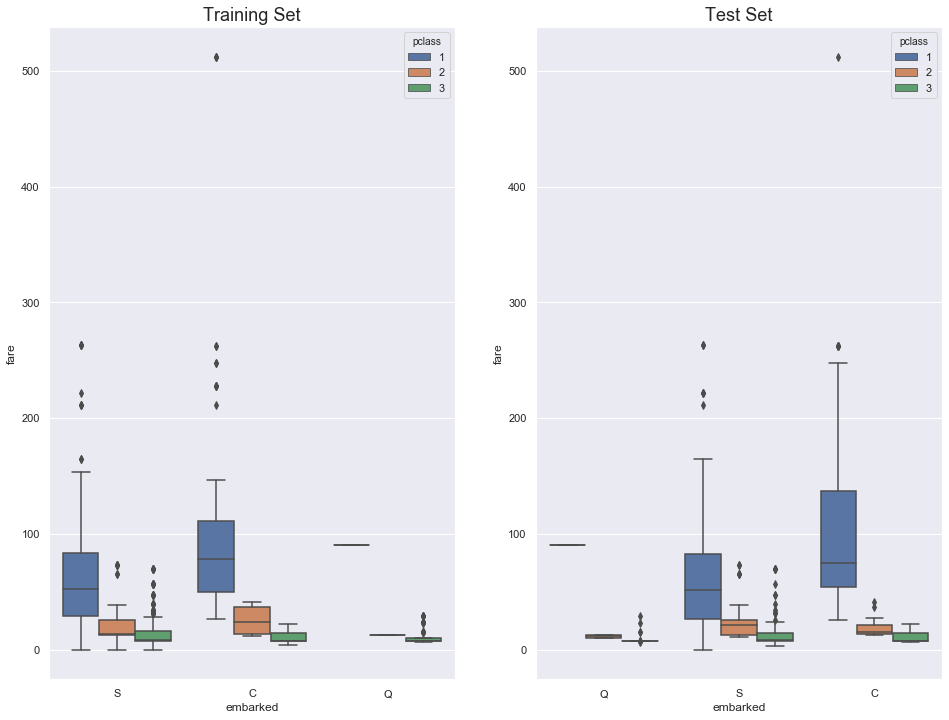

In [47]:
fig, ax = plt.subplots(figsize = (16, 12), ncols = 2)
ax1 = sns.boxplot(x = 'embarked', y = 'fare', hue = 'pclass', data = train, ax = ax[0]);
ax2 = sns.boxplot(x = 'embarked', y = 'fare', hue = 'pclass', data = test, ax = ax[1]);
ax1.set_title('Training Set', fontsize = 18)
ax2.set_title('Test Set', fontsize = 18)

fig.show()

For 1st class at fare of 80, Cherbourg's median seems to fit the best. Thus, instead of replacing them with mode value S, we should replace them with C

In [48]:
train.embarked.fillna('C', inplace = True)

#### Cabin

In [49]:
print('Train Cabin Missing: ' + str(train.cabin.isnull().sum()/len(train.cabin)))
print('Test Cabin Missing: ' + str(test.cabin.isnull().sum()/len(test.cabin)))

Train Cabin Missing: 0.7710437710437711
Test Cabin Missing: 0.7822966507177034


Cabin for both datasets have almost 80% of it missing. In this case we can:
1. get rid of the whole column
2. try to find similar characteristics and fill them in

For now, we will change them to N and combine train and test dataset

In [50]:
# take out survivors before joining the two
survivors = train.survived
print(survivors)
train.drop(['survived'], axis = 1, inplace = True)
all_data = pd.concat([train, test], ignore_index = False)
all_data.cabin.fillna('N', inplace = True)

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: survived, Length: 891, dtype: int64


In [51]:
all_data.cabin.value_counts()

N                  1014
C23 C25 C27           6
B57 B59 B63 B66       5
G6                    5
B96 B98               4
                   ... 
C70                   1
B52 B54 B56           1
C49                   1
C30                   1
C28                   1
Name: cabin, Length: 187, dtype: int64

Since all values begin with alphabets and values with multiple cabins all start with the same letter, extract the first letter from every value and assign as the value

In [52]:
all_data.cabin = [i[0] for i in all_data.cabin]

In [53]:
percent_value_counts(all_data, 'cabin')

,Total,Percent
N,1014,77.46
C,94,7.18
B,65,4.97
D,46,3.51
E,41,3.13
A,22,1.68
F,21,1.60
G,5,0.38
T,1,0.08


However, this only shows the frequency of each cabin letter, and we want to try to fit them a little better than just the frequency. So, finding the average fares for each letter:

In [54]:
all_data.groupby('cabin')['fare'].mean().sort_values()

cabin
G     14.205000
F     18.079367
N     19.132707
T     35.500000
A     41.244314
D     53.007339
E     54.564634
C    107.926598
B    122.383078
Name: fare, dtype: float64

From this we can guess that cabin might be correlated with fare price. Thus, let's assign cabin letters based on their fares compared to the middle point of average fares of each cabin letters

In [55]:
def cabin_estimator(i):
    """ grouping cabin feature by the first letter"""
    a = 0
    if i < 16:
        a = 'G'
    elif i >= 16 and i < 27:
        a = 'F'
    elif i >= 27 and i < 38:
        a = 'T'
    elif i >= 38 and i < 47:
        a = 'A'
    elif i >= 47 and i < 53:
        a = 'E'
    elif i >= 53 and i < 54: # maybe got switched up with E?
        a = 'D'
    elif i >= 54 and i < 116:
        a = 'C'
    else:
        a = 'B'
    return a

In [56]:
with_n = all_data[all_data.cabin == 'N']
without_n = all_data[all_data.cabin != 'N']

In [57]:
# apply cabin_estimator to convert all N
with_n['cabin'] = with_n.fare.apply(lambda x: cabin_estimator(x))

# join back the two
all_data = pd.concat([with_n, without_n], axis = 0)

# sort out passengerid to separate back train and test
all_data.sort_values(by = 'passengerid', inplace = True)

# separate back
train = all_data[:891]
test = all_data[891:]

# add back survived
train['survived'] = survivors

#### Fare

There is only one value missing in fare column, which is in test:

In [58]:
test[test.fare.isnull()]

,passengerid,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,B,S


We can fill in simply using the average, but we can try to classify as much as possible before taking the average.

In [59]:
test.fare.fillna(test[ (test.pclass == 3) &
                     (test.embarked == 'S') &
                     (test.sex == 'male')].fare.mean(), inplace = True)

#### Age

In [60]:
print('Train age missing value: ' + str((train.age.isnull().sum()/len(train)) * 100) + '%')
print('Test age missing value: ' + str((test.age.isnull().sum()/len(test)) * 100) + '%')

Train age missing value: 19.865319865319865%
Test age missing value: 20.574162679425836%


1/5 of the values in age column in both datasets are missing, but since age seems to be a crucial factor in determining survival, instead of simply replacing them with median, mean, or mode, we will use Random Forest Regressor to impute the missing values later

## Visualization and Correlation between Features (EDA)

Some Assumptions:
* Gender: female survived more
* Pclass: higher socio-economic status passenger survived more
* Age: younger passenger survived more
* Fare: passenger with higher fare survived more, but this is probably correlated to pclass

### Gender

Text(0.5, 0, 'Sex')

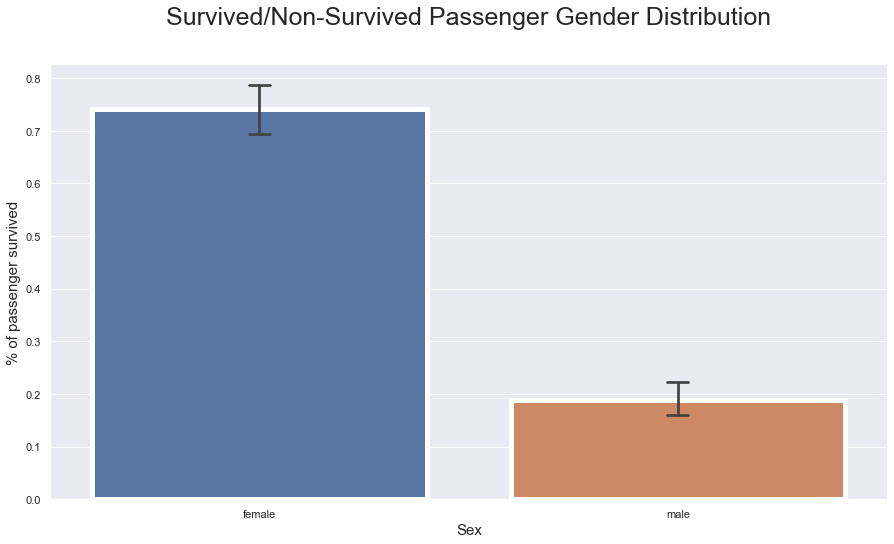

In [61]:
sns.set(style = 'darkgrid')
plt.subplots(figsize = (15, 8))
ax = sns.barplot(x = 'sex',
                y = 'survived',
                data = train,
                linewidth = 5,
                order = ['female', 'male'],
                capsize = 0.05)
plt.title('Survived/Non-Survived Passenger Gender Distribution', fontsize = 25, loc = 'center', pad = 40)
plt.ylabel('% of passenger survived', fontsize = 15)
plt.xlabel('Sex', fontsize = 15)


We can see that survival between the two genders are different by a lot

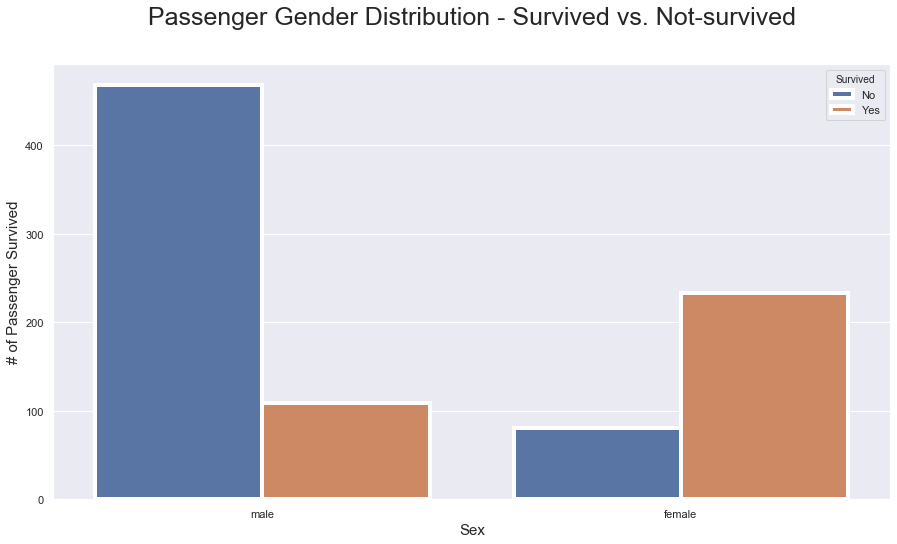

In [62]:
sns.set(style = 'darkgrid')
plt.subplots(figsize = (15, 8))
ax = sns.countplot(x = 'sex', 
                  hue = 'survived',
                  data = train,
                  linewidth = 4)

plt.title('Passenger Gender Distribution - Survived vs. Not-survived', fontsize = 25, pad = 40)
plt.xlabel('Sex', fontsize = 15)
plt.ylabel('# of Passenger Survived', fontsize = 15)

leg = ax.get_legend()
leg.set_title('Survived')
legs = leg.texts
legs[0].set_text('No')
legs[1].set_text('Yes')
plt.show()

Proves that a lot more females survived than male

### Class

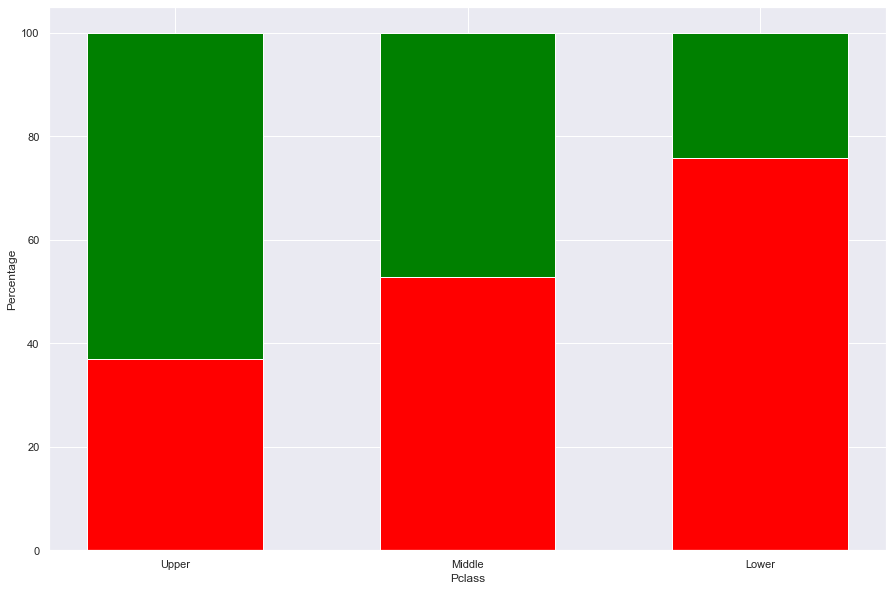

In [63]:
temp = train[['pclass', 'survived', 'passengerid']].groupby(['pclass', 'survived']).count().reset_index()
temp_df = pd.pivot_table(temp, values = 'passengerid', index = 'pclass', columns = 'survived')
names = ['No', 'Yes']
temp_df.columns = names
r = [0, 1, 2]
totals = [i + j for i, j in zip(temp_df['No'], temp_df['Yes'])]
No_s = [i / j * 100 for i, j in zip(temp_df['No'], totals)]
Yes_s = [i / j * 100 for i, j in zip(temp_df['Yes'], totals)]

# # Plotting
plt.subplots(figsize = (15, 10))
barWidth = 0.6
names = ('Upper', 'Middle', 'Lower')

# # Green bars
plt.bar(r, No_s, color = 'Red', edgecolor = 'white', width = barWidth)
# Orange bars
plt.bar(r, Yes_s, bottom = No_s, color = 'Green', edgecolor = 'white', width = barWidth)

# # Custom x axis
plt.xticks(r, names)
plt.xlabel('Pclass')
plt.ylabel('Percentage')

# # Show graphic
plt.show()

([<matplotlib.axis.XTick at 0x181318ea748>,
 <a list of 3 Text xticklabel objects>)

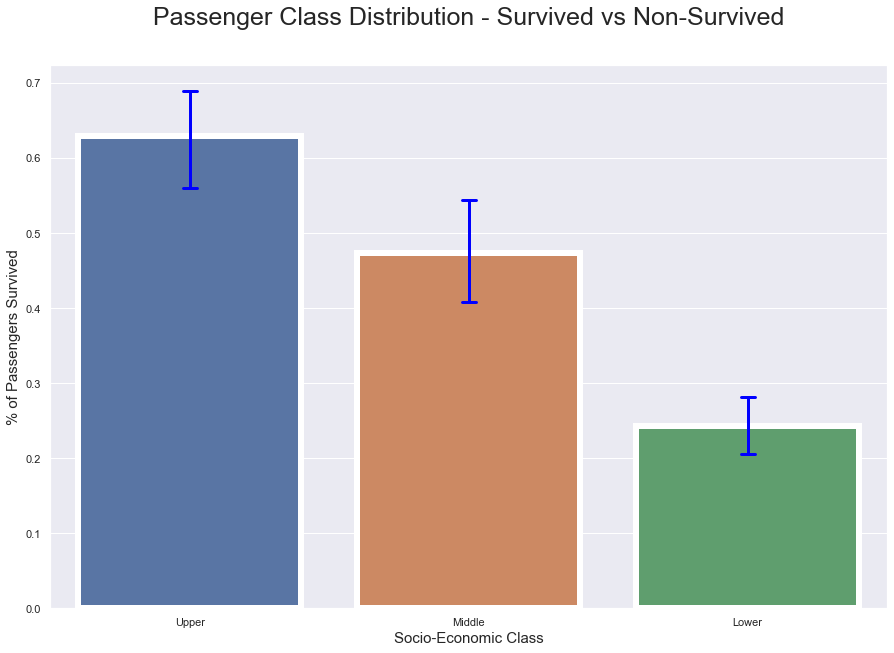

In [64]:
plt.subplots(figsize = (15, 10))
sns.barplot(x = 'pclass',
           y = 'survived',
           data = train,
           linewidth = 6,
           capsize = 0.05,
           errcolor = 'blue',
           errwidth = 3)

plt.title('Passenger Class Distribution - Survived vs Non-Survived', fontsize = 25, pad = 40)
plt.xlabel('Socio-Economic Class', fontsize = 15)
plt.ylabel('% of Passengers Survived', fontsize = 15)
names = ['Upper', 'Middle', 'Lower']
val = [0, 1, 2]
plt.xticks(val, names)

([<matplotlib.axis.XTick at 0x18132094e48>,
 <a list of 3 Text xticklabel objects>)

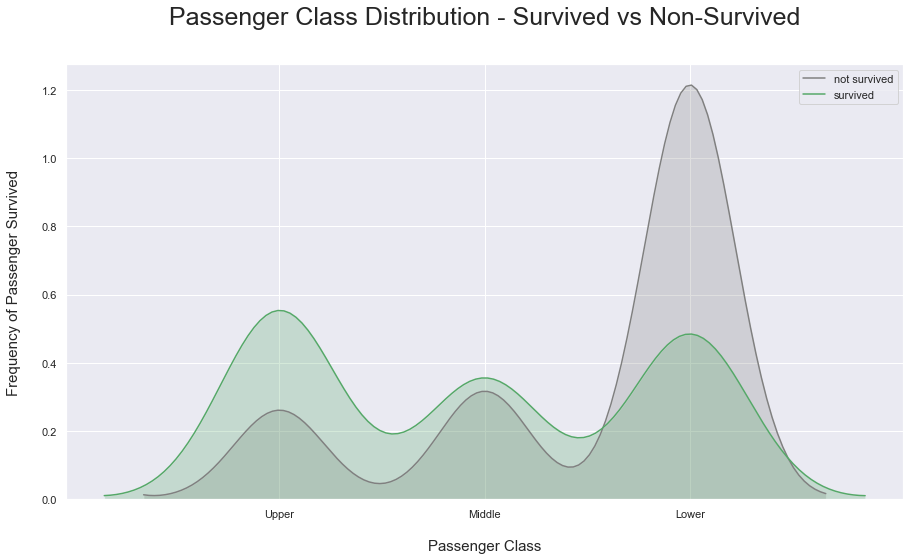

In [65]:
fig = plt.figure(figsize = (15, 8))
ax = sns.kdeplot(train.pclass[train.survived == 0],
                color = 'gray',
                shade = True,
                label = 'not survived')
ax = sns.kdeplot(train.pclass[train.survived == 1],
                color = 'g',
                shade = True,
                label = 'survived')
plt.title('Passenger Class Distribution - Survived vs Non-Survived', fontsize = 25, pad = 40)
plt.ylabel('Frequency of Passenger Survived', fontsize = 15, labelpad = 20)
plt.xlabel('Passenger Class', fontsize = 15, labelpad = 20)

labels = ['Upper', 'Middle', 'Lower']
plt.xticks(sorted(train.pclass.unique()), labels)